# Homework 1 for Jesse Bloom's lectures in Genome Sciences 541
This homework is due on Tuesday, May 17. Please try to finish it before class so that we can go over it in class.

Please complete this homework by downloading this iPython notebook and filling in the empty cells that follow each question with code that answers the question and plots showing the answers.

## Part 1: Simulation of pairs of sequences under two nucleotide models, and estimation of evolutionary distance between them using the Jukes-Cantor model
In the [last lecture](jbloom.github.io/GenomeSciences541/lecture_2.html), we discussed two nucleotide model, the simple Jukes-Cantor and the more complex HKY85 model. We are going to simulate sequence divergence under both models, and then estimate the evolutionary distance (branch length) between them using the simpler Jukes-Cantor model.

### Jukes Cantor model
The first model was the [Jukes-Cantor model](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#JC69_model_.28Jukes_and_Cantor.2C_1969.29.5B1.5D). This is a very simple model that assumes every nucleotide is likely to mutate into every other nucleotide. Recall that the substitution matrix for the Jukes-Cantor model is
$$\mathbf{P} = \begin{bmatrix} -1 & 1/3 & 1/3 & 1/3 \\ 1/3 & -1 & 1/3 & 1/3 \\ 1/3 & 1/3 & -1 & 1/3 \\ 1/3 & 1/3 & 1/3 & -1 \end{bmatrix}$$

As described in the lecture, it turns out that the elements of $e^{\mu t \mathbf{P}}$ are given by
$$\left[e^{\mu t \mathbf{P}}\right]_{ij} = 
\begin{cases} 
\frac{1}{4} + \frac{3}{4} e^{-\mu t} & \mbox{if } i = j\\
\frac{1}{4} - \frac{1}{4} e^{-\mu t} &\mbox{if } i \ne j\\
\end{cases}$$

If we start with a given sequence, the expected identity $f$ to that starting sequence after an elapsed time $\mu t$ is $f = \frac{1}{4} + \frac{3}{4} e^{-\mu t}$. So given the identity $f$ from the starting sequence, you can estimate $\mu t$ by solving that equation for $\mu t$.

### HKY85 model
The second model was the [HKY85 model](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#HKY85_model_.28Hasegawa.2C_Kishino_and_Yano_1985.29.5B4.5D). This model allows the sequences to have unequal nucleotide frequencies, which we will denote $\phi_A$, $\phi_C$, $\phi_G$, and $\phi_T$ where $1 = \sum_x \phi_x$. This model also allows transitions to occur at a different rate than transversions: the elevation of the transition rate over the transversion rate is denoted by $\kappa$.  

So the substitution matrix for the HKY85 model is:
$$
\mathbf{P} = 
\begin{bmatrix}
* & \phi_C & \kappa \phi_G & \phi_T \\
\phi_A & * & \phi_G & \kappa \phi_T \\
\kappa \phi_A & \phi_C & * & \phi_T \\
\phi_A & \kappa \phi_C & \phi_G & * \\
\end{bmatrix}
$$
where the $*$ indicates that the diagonal elements are chosen such that $0 = \sum_j P_{ij}$.

### Simulations with `pyvolve`
We are going to simulate the evolution using the [pyvolve](https://github.com/sjspielman/pyvolve) software package.

[pyvolve](https://github.com/sjspielman/pyvolve) is written by [Stephanie Spielman](http://sjspielman.org/) and [Claus Wilke](http://wilkelab.org/) (for anyone interested, they are giving seminars at the Hutch [on Monday](https://www.fredhutch.org/en/labs/phs/projects/herbold-computational-biology-program/seminars-events.html) and [in July](http://www.cidid.org/events/2016/7/21/cidid-seminar-stephanie-spielman), respectively).

There is a manual for [pyvolve](https://github.com/sjspielman/pyvolve) that can be [downloaded here](https://github.com/sjspielman/pyvolve/raw/master/user_manual/pyvolve_manual.pdf). 

The first thing you need to do is install the program. Assuming you have a reasonable implementation of `Python` with `pip` installed, you should be able to do this with `pip install pyvolve`. 

First you need to set up the nucleotide models. In the example below, I do this for the Jukes-Cantor model:

In [8]:
import pyvolve

# following section 6.1 of pyvolve manual
freqs = [0.25, 0.25, 0.25, 0.25] # equilibrium nucleotide frequencies all equal for Jukes Cantor
custom_mu = {'AC':1, 'AG':1, 'AT':1, 'CG':1, 'CT':1, 'GT':1} # rates all equal, set to one
jukescantor_model = pyvolve.Model("nucleotide", {'mu':custom_mu, 'state_freqs':freqs})

Now we use [pyvolve](https://github.com/sjspielman/pyvolve) to simulate the evolution along a simple two-taxon tree. Note that the tree is specified below in [Newick format](https://en.wikipedia.org/wiki/Newick_format). The sequence is of length 1000 nucleotides, and we simulate for a range of times going from 0 to 1.9. After each simulation, we compute the pairwise divergence between the two sequences on the tree.

In [9]:
import numpy
import Bio.SeqIO # import Biopython, you may need to install this

seqlength = 10000 # sequences of 1000 nucleotides

times = numpy.arange(0, 2, 0.1) # divergence times

actual_identities = []
for t in times: # loop over different branch lengths
    tree = pyvolve.read_tree(tree='(s1:{0},s2:{0});'.format(t / 2.0)) # as in section 5 of pyvolve manual
    partition = pyvolve.Partition(models=jukescantor_model, size=seqlength) # as in section 7 of pyvolve manual
    evolver = pyvolve.Evolver(tree=tree, partitions=partition) # as in section 8 of pyvolve manual
    seqfile = 'seqs_{0}.fasta'.format(t)
    evolver(seqfile=seqfile) # run evolve specifying output sequence file
    seqs = list(Bio.SeqIO.parse(seqfile, 'fasta'))
    assert len(seqs) == 2
    fracident = len([i for i in range(seqlength) if seqs[0].seq[i] == seqs[1].seq[i]]) / float(seqlength)
    actual_identities.append(fracident)  

After these simulations, the variable `actual_identities` has a list of the actual identities after the simulation for each divergence time in `times`. 

**Question 1: Use the equation that relates $\mu t$ to the expected identity $f$ for the Jukes-Cantor model to estimate $\mu t$ for each simulated timepoint. The figuire below plots estimated divergence times under the Jukes-Cantor model versus the actual times used in the simulation. What does this relationship look like, and is it what you expect?**

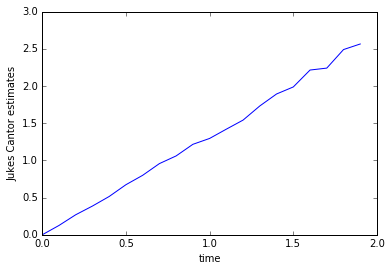

In [10]:
# Compute the Jukes-Cantor estimates of mu*t and plot them here
%matplotlib inline
import matplotlib.pyplot as plt
import math

def jc_estimate(f):
    t = -math.log((4 * f - 1) / 3.)
    return t

estimates = map(jc_estimate, actual_identities)

plt.plot(times, estimates)
plt.xlabel('time')
plt.ylabel('Jukes Cantor estimates')

**Question 2: Now define the HKY85 model for pyvolve simulations similar to how the Jukes-Cantor was defined above. Perform similar simulations under the HKY85 model using $\kappa = 4$, $\phi_A = \phi_T = 0.35$, and $\phi_C = \phi_G = 0.15$, and then compute the estimated divergences using the Jukes-Cantor model. Plot the actual versus estimated divergences. How well does the Jukes-Cantor estimate perform when the HKY85 model is the true one?**
_Below is code that defines an HKY85 model for a **different** set of parameters than the one in the question. Specifically, the parameters below again define a Jukes-Cantor model. Make this model correct for HKY85 specifications in the question, and then do the simulations and answer the question._

In [11]:
# Simulations under HKY85 model, and comparison of actual and estimated distances.
# following section 6.1 of pyvolve manual
freqs = [0.25, 0.25, 0.25, 0.25] # the equilibrium nucleotide frequencies can differ for HKY85
custom_mu = {'AC':1, 'AG':1, 'AT':1, 'CG':1, 'CT':1, 'GT':1} # transitions / transversions can have diff rates for HKY85
hky85_model = pyvolve.Model("nucleotide", {'mu':custom_mu, 'state_freqs':freqs})

## Part 2: Simulating a more complex phylogenetic tree and analysis with `RAxML`

Now we are going to simulate a more complex tree phylogeny using `pyvolve`. Everything is exactly as in _Part 1_, except now we read the tree from the file [`NP_tree.newick`, which you can download here](https://github.com/jbloom/GenomeSciences541/blob/gh-pages/source/homework_1/NP_tree.newick). We then simply simulate evolution along this sequence using the branch lengths that it gives you.

Although it is not required, you might look at this tree using some viewer you download such as [FigTree](http://tree.bio.ed.ac.uk/software/figtree/).

Here is the simulation done for the Jukes-Cantor model to create the file `JukesCantor_simulated_NP_alignment.fasta`:

In [12]:
treefile = 'NP_tree.newick'

# We use the jukescantor_model defined above
tree = pyvolve.read_tree(file=treefile) # as in section 5 of pyvolve manual
partition = pyvolve.Partition(models=hky85_model, size=seqlength) # as in section 7 of pyvolve manual
evolver = pyvolve.Evolver(tree=tree, partitions=partition) # as in section 8 of pyvolve manual
jc_simulated_alignment = 'JukesCantor_simulated_NP_alignment.fasta'
evolver(seqfile=jc_simulated_alignment)

Now we are going to use [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html) to fit a phylogeny to that alignment. There is a decent chance that [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html) is already installed if you are using a scientific computing cluster. If not, install it (for a Mac, it can be installed using `MacPorts`).

In [13]:
# The -T option may or may not be needed depending on whether you have a multi-threaded version of raxml
!raxml -s {jc_simulated_alignment} -n jukescantor -m GTRCAT -p 1 -T 2


RAxML can't, parse the alignment file as phylip file 
it will now try to parse it as FASTA file


This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1


This is RAxML version 7.7.6 released by Alexandros Stamatakis on August 29 2013.

With greatly appreciated code contributions by:
Andre Aberer (HITS)
Simon Berger (HITS)
Nick Pattengale (Sandia)
Wayne Pfeiffer (SDSC)
Akifumi S. Tanabe (NRIFS)


Alignment has 1565 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 0.00%

RAxML rapid hill-climbing mode

Using 1 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
ML estimate of 25 per site rate categories

Likelihood of final tree will be evaluated and optimized under GAMMA

GAMMA Model parameters will be estimated up to an accuracy of 0.1000000000 Log Like

[RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html) is **not** using the Jukes-Cantor model, it is using the more general [GTR model](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#GTR:_Generalised_time-reversible_.28Tavar.C3.A9_1986.29.5B9.5D). So let's look and see if it inferred model parameters close to what we used in our simulations. To do this, we look in `RAxML_info.jukescantor` file:

In [14]:
!cat RAxML_info.jukescantor



This is RAxML version 7.7.6 released by Alexandros Stamatakis on August 29 2013.

With greatly appreciated code contributions by:
Andre Aberer (HITS)
Simon Berger (HITS)
Nick Pattengale (Sandia)
Wayne Pfeiffer (SDSC)
Akifumi S. Tanabe (NRIFS)


Alignment has 1565 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 0.00%

RAxML rapid hill-climbing mode

Using 1 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
ML estimate of 25 per site rate categories

Likelihood of final tree will be evaluated and optimized under GAMMA

GAMMA Model parameters will be estimated up to an accuracy of 0.1000000000 Log Likelihood units

Partition: 0
Alignment Patterns: 1565
Name: No Name Provided
DataType: DNA
Substitution Matrix: GTR




RAxML was called as follows:

raxml -s JukesCantor_sim

This file gives the base frequencies and rates inferred by [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html). 

**Question 3: What are the base frequencies and rates inferred by [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html), and how do they compare to what you expect?**

_Put your answer to question 3 here_

**Question 4: Repeat the simulations and inferences using the HKY85 model that you defined in Part 1. Now what are the base frequencies and rates inferred by [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html), and how do they compare to what you expect and what [RAxML](http://sco.h-its.org/exelixis/web/software/raxml/index.html) inferred when you used the Jukes-Cantor model?**

_Put your answer to question 4 here_